In [1]:
!pip install numpy pandas matplotlib scikit-learn scipy keras tensorflow keras_tuner --quiet

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import keras_tuner as kt
import joblib

# Prepare Data

## Load Preprocessed Data

In [3]:
data = pd.read_csv('data/fulltext_preprocessed_data.csv')
data.head()

,full_text,full_tokens,full_text_lemmatized,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,"['house', 'aide', 'even', 'see', 'letter', 'ja...",house aide even see letter jason house aide ev...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","['hillary', 'clinton', 'big', 'woman', 'campus...",hillary clinton big woman campus ever get feel...,0
2,Why the Truth Might Get You Fired Why the Trut...,"['truth', 'might', 'get', 'fired', 'truth', 'm...",truth might get fired truth might get fired oc...,1
3,15 Civilians Killed In Single US Airstrike Hav...,"['single', 'single', 'rate', 'american', 'high...",single single rate american higher engaged act...,1
4,Iranian woman jailed for fictional unpublished...,"['iranian', 'woman', 'fictional', 'unpublished...",iranian woman fictional unpublished story woma...,1


In [4]:
data.shape

(20546, 4)

In [5]:
style_df = pd.read_csv('data/style_features.csv').drop(columns='label')
style_df.head()

,average_word_length,average_sentence_length,vocabulary_richness,url_ratio,all_caps_ratio,exclamations_ratio,questions_ratio,digits_ratio,flesch_reading_ease_score,noun_ratio,verb_ratio,adjective_ratio,adverb_ratio,pronoun_ratio,proper_noun_ratio,punctuation_ratio
0,4.737278,25.131579,0.463905,0.000000,0.011834,0.0,0.000000,0.004387,48.159824,0.136095,0.126627,0.057988,0.057988,0.102959,0.165680,0.020738
1,4.747504,25.030303,0.543509,0.000000,0.009986,0.0,0.000954,0.007393,54.114539,0.194009,0.119829,0.064194,0.052782,0.111270,0.102710,0.027427
2,4.934295,25.224138,0.469551,0.006410,0.006410,0.0,0.000519,0.002986,45.803364,0.196314,0.111378,0.085737,0.048878,0.081731,0.103365,0.028171
3,4.732852,23.222222,0.453069,0.001805,0.034296,0.0,0.000000,0.009747,52.086600,0.209386,0.120939,0.075812,0.027076,0.050542,0.124549,0.018276
4,5.104294,37.600000,0.595092,0.000000,0.000000,0.0,0.000000,0.005848,27.212727,0.257669,0.153374,0.049080,0.012270,0.067485,0.092025,0.021442


In [6]:
style_df.shape

(20546, 16)

In [7]:
X = data['full_text_lemmatized'].astype(str)
y = data['label']

## Train-Test Split

In [8]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_text, X_val_text, y_train, y_val = train_test_split(X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [9]:
X_train_style = style_df.loc[X_train_text.index].values
X_val_style = style_df.loc[X_val_text.index].values
X_test_style = style_df.loc[X_test_text.index].values

## TF-IDF Features

In [10]:
tfidf = joblib.load('artifacts/tfidf_vectorizer.pkl')

C:\Users\Aleena\anaconda3\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Aleena\anaconda3\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
X_train_tfidf = tfidf.transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [12]:
X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape

((13148, 50000), (3288, 50000), (4110, 50000))

# ANN

In [16]:
EPOCHS=30
BATCH_SIZE=128
PATIENCE_EARLYSTOP=5

## TF-IDF Only

In [14]:
model = Sequential()
model.add(Input(shape=(50000,)))
model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │   102,402,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,156,609 (401.14 MB)

 Trainable params: 105,156,609 (401.14 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
estop = EarlyStopping(monitor='val_loss', mode='min',
                      min_delta=1e-5, patience=PATIENCE_EARLYSTOP,
                      restore_best_weights=True, verbose=1)
model.fit(X_train_tfidf, y_train, 
          validation_data=(X_val_tfidf, y_val),
          epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[estop], verbose=1)

Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9337 - loss: 0.7994 - val_accuracy: 0.9523 - val_loss: 0.5435
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9673 - loss: 0.4430 - val_accuracy: 0.9510 - val_loss: 0.4786
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.9746 - loss: 0.3907 - val_accuracy: 0.9456 - val_loss: 0.4749
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9811 - loss: 0.3325 - val_accuracy: 0.9519 - val_loss: 0.4073
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9847 - loss: 0.2913 - val_accuracy: 0.9541 - val_loss: 0.3786
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9873 - loss: 0.2548 - val_accuracy: 0.9519 - val_loss: 0.3497
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9883 - loss: 0.2212 - val_accuracy: 0.9529 - val_loss: 0.3417
Epoch 8/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9899 - loss: 0.2098 - val_accu

In [18]:
test_loss, test_accuracy = model.evaluate(X_test_tfidf, y_test)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.9530 - loss: 0.2888
Test accuracy: 0.9530413746833801
Test loss: 0.2888094484806061


In [19]:
y_pred = np.array([[1] if pred>=0.5 else [0] for pred in model.predict(X_test_tfidf)])

129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2078
           1       0.95      0.95      0.95      2032

    accuracy                           0.95      4110
   macro avg       0.95      0.95      0.95      4110
weighted avg       0.95      0.95      0.95      4110



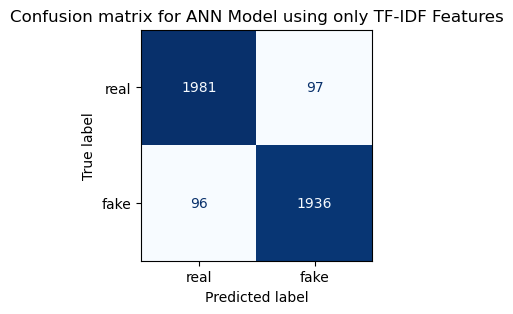

In [20]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real','fake'])
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.title(f'Confusion matrix for ANN Model using only TF-IDF Features')
plt.show()

## TF-IDF + Style Features

In [21]:
scaler = MinMaxScaler()
X_train_style_scaled = scaler.fit_transform(X_train_style)
X_val_style_scaled = scaler.transform(X_val_style)
X_test_style_scaled = scaler.transform(X_test_style)

In [22]:
# combining sparse tfidf with dense scaled style features
X_train_combined_scaled = hstack([X_train_tfidf, X_train_style_scaled])
X_val_combined_scaled = hstack([X_val_tfidf, X_val_style_scaled])
X_test_combined_scaled = hstack([X_test_tfidf, X_test_style_scaled])

In [23]:
X_train_combined_scaled.shape, X_val_combined_scaled.shape, X_test_combined_scaled.shape

((13148, 50016), (3288, 50016), (4110, 50016))

In [27]:
model2 = Sequential()
model2.add(Input(shape=(50016,)))
model2.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.3))
model2.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.3))
model2.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.3))
model2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 2048)           │   102,434,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,189,377 (401.27 MB)

 Trainable params: 105,189,377 (401.27 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
estop = EarlyStopping(monitor='val_loss', mode='min',
                      min_delta=1e-5, patience=PATIENCE_EARLYSTOP,
                      restore_best_weights=True, verbose=1)
model2.fit(X_train_combined_scaled, y_train, 
          validation_data=(X_val_combined_scaled, y_val),
          epochs=EPOCHS, batch_size=BATCH_SIZE,
          callbacks=[estop], verbose=1)

Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.9032 - loss: 1.1901 - val_accuracy: 0.9462 - val_loss: 0.6006
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.9640 - loss: 0.4901 - val_accuracy: 0.9465 - val_loss: 0.4909
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9716 - loss: 0.3965 - val_accuracy: 0.9544 - val_loss: 0.4366
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9792 - loss: 0.3232 - val_accuracy: 0.9389 - val_loss: 0.4522
Epoch 5/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9806 - loss: 0.3151 - val_accuracy: 0.9550 - val_loss: 0.3755
Epoch 6/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9862 - loss: 0.2574 - val_accuracy: 0.9535 - val_loss: 0.3598
Epoch 7/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9860 - loss: 0.2463 - val_accuracy: 0.9541 - val_loss: 0.3308
Epoch 8/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9911 - loss: 0.2105 - val_accu

In [29]:
test_loss, test_accuracy = model2.evaluate(X_test_combined_scaled, y_test)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

129/129 ━━━━━━━━━━━━━━━━━━━━ 61s 470ms/step - accuracy: 0.9543 - loss: 0.2896
Test accuracy: 0.9542579054832458
Test loss: 0.2895994484424591


In [31]:
y_pred2 = np.array([[1] if pred>=0.5 else [0] for pred in model2.predict(X_test_combined_scaled)])

129/129 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2078
           1       0.95      0.96      0.95      2032

    accuracy                           0.95      4110
   macro avg       0.95      0.95      0.95      4110
weighted avg       0.95      0.95      0.95      4110



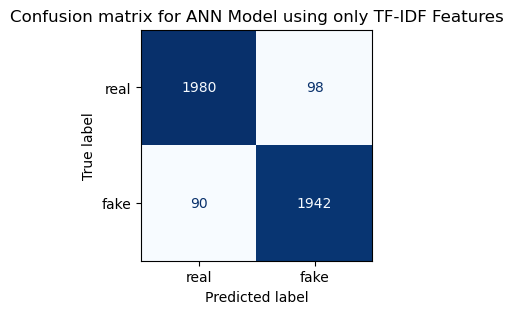

In [32]:
print(classification_report(y_test, y_pred2))
cm = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(3,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real','fake'])
disp.plot(cmap='Blues', colorbar=False, ax=ax)
plt.title(f'Confusion matrix for ANN Model using only TF-IDF Features')
plt.show()

## Save Best Model

In [33]:
if model.evaluate(X_test_tfidf, y_test)[1] >= model2.evaluate(X_test_combined_scaled, y_test)[1]:
    best_model = model
else:
    best_model = model2

129/129 ━━━━━━━━━━━━━━━━━━━━ 59s 448ms/step - accuracy: 0.9530 - loss: 0.2888 
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 401ms/step - accuracy: 0.9543 - loss: 0.2896


In [34]:
best_model.save('artifacts/tfidf_ann.keras')